## Result Comparison

In [3]:
import pandas as pd

In [4]:
df_party_qv = pd.read_csv("./qv/party_results_qv.csv")

In [5]:
df_party_qv['match_tuned'] = df_party_qv['Fine-tuned Qwen 3'] == df_party_qv['true_label']

In [6]:
df_party_qv.head()

,Base Qwen 3,Fine-tuned Qwen 3,true_label,match_tuned
0,AUST,ÖVP,GRÜNE,False
1,AUST,GRÜNE,JETZT,False
2,AUSTRIAN PARTY: AUST,ÖVP,FPÖ,False
3,SPÖ,ÖVP,NEOS,False
4,AUSTRIAN PARTY: AUST,GRÜNE,FPÖ,False


In [7]:
df_party_qv['match_tuned'].value_counts()

match_tuned
False    1681
True      780
Name: count, dtype: int64

In [8]:
df_orient_qv = pd.read_csv("./qv/orient_results_qv.csv")

In [9]:
df_orient_qv['match_tuned'] = df_orient_qv['Fine-tuned Qwen 3'] == df_orient_qv['true_label']
df_orient_qv['part_match_tuned'] = df_orient_qv.apply(
    lambda row: str(row['true_label']) in str(row['Fine-tuned Qwen 3']) or
                str(row['Fine-tuned Qwen 3']) in str(row['true_label']),
    axis=1
)

In [10]:
df_orient_qv['match_tuned'].value_counts()

match_tuned
False    1842
True      619
Name: count, dtype: int64

In [11]:
df_orient_qv['part_match_tuned'].value_counts()

part_match_tuned
True     1279
False    1182
Name: count, dtype: int64

In [12]:
def calculate_exact_match_accuracy(predictions, true_labels):
    matches = sum(pred.strip().lower() == true.strip().lower() for pred, true in zip(predictions, true_labels))
    return matches / len(predictions)

def calculate_partial_match_accuracy(predictions, true_labels):
    matches = 0
    for pred, true in zip(predictions, true_labels):
        if str(true) in str(pred) or str(pred) in str(true):
            matches += 1
    return matches / len(predictions)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_precision_recall_macro(predictions,true_labels):
    precision = precision_score(true_labels,predictions,average='macro')
    recall = recall_score(true_labels,predictions,average='macro')
    f1 = f1_score(true_labels,predictions,average='macro')
    return precision, recall, f1

'''def calculate_precision_recall_micro(predictions,true_labels):
    precision = precision_score(true_labels,predictions,average='micro')
    recall = recall_score(true_labels,predictions,average='micro')
    f1 = f1_score(true_labels,predictions,average='micro')
    return precision, recall, f1'''

def calculate_precision_recall_weighted(predictions,true_labels):
    precision = precision_score(true_labels,predictions,average='weighted')
    recall = recall_score(true_labels,predictions,average='weighted')
    f1 = f1_score(true_labels,predictions,average='weighted')
    return precision, recall, f1

In [14]:
from sklearn.metrics import balanced_accuracy_score

def get_metrics(base,fine,true,metrics_dict):
    base_precision_mac, base_recall_mac, base_f1_mac =calculate_precision_recall_macro(base,true)
    base_precision_wei, base_recall_wei, base_f1_wei =calculate_precision_recall_weighted(base,true)
    metrics_dict['Base Qwen 3'] = {
        'EA': calculate_exact_match_accuracy(base, true),
        'PA': calculate_partial_match_accuracy(base, true),
        'BA': balanced_accuracy_score(base, true),
        'P (m)': base_precision_mac,
        'R(m)': base_recall_mac,
        'F1(m)': base_f1_mac,
        'P (w)': base_precision_wei,
        'R(w)': base_recall_wei,
        'F1(w)': base_f1_wei,
    }
    fine_precision_mac, fine_recall_mac, fine_f1_mac =calculate_precision_recall_macro(fine,true)
    fine_precision_wei, fine_recall_wei, fine_f1_wei =calculate_precision_recall_weighted(fine,true)
    metrics_dict['Fine-tuned Qwen 3'] = {
        'EA': calculate_exact_match_accuracy(fine, true),
        'PA': calculate_partial_match_accuracy(fine, true),
        'BA': balanced_accuracy_score(fine, true),
        'P (m)': fine_precision_mac,
        'R(m)': fine_recall_mac,
        'F1(m)': fine_f1_mac,
        'P (w)': fine_precision_wei,
        'R(w)': fine_recall_wei,
        'F1(w)': fine_f1_wei,
    }
    return metrics_dict


In [15]:
party_metrics_summary = {}
party_metrics_summary = get_metrics(df_party_qv['Base Qwen 3'],df_party_qv['Fine-tuned Qwen 3'],df_party_qv['true_label'],party_metrics_summary)

c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

In [16]:
party_metrics_df = (pd.DataFrame(party_metrics_summary).T *100).round(2)

In [17]:
party_metrics_df

,EA,PA,BA,P (m),R(m),F1(m),P (w),R(w),F1(w)
Base Qwen 3,5.20,6.58,1.95,1.94,0.18,0.30,47.46,5.20,8.43
Fine-tuned Qwen 3,31.69,31.69,45.53,45.53,23.20,21.75,49.90,31.69,30.10


In [18]:
party_metrics_df.to_latex(float_format="%.2f")

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n & EA & PA & BA & P (m) & R(m) & F1(m) & P (w) & R(w) & F1(w) \\\\\n\\midrule\nBase Qwen 3 & 5.20 & 6.58 & 1.95 & 1.94 & 0.18 & 0.30 & 47.46 & 5.20 & 8.43 \\\\\nFine-tuned Qwen 3 & 31.69 & 31.69 & 45.53 & 45.53 & 23.20 & 21.75 & 49.90 & 31.69 & 30.10 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
df_party_qv['true_label'].unique()

array(['GRÜNE', 'JETZT', 'FPÖ', 'NEOS', 'SPÖ', 'ÖVP'], dtype=object)

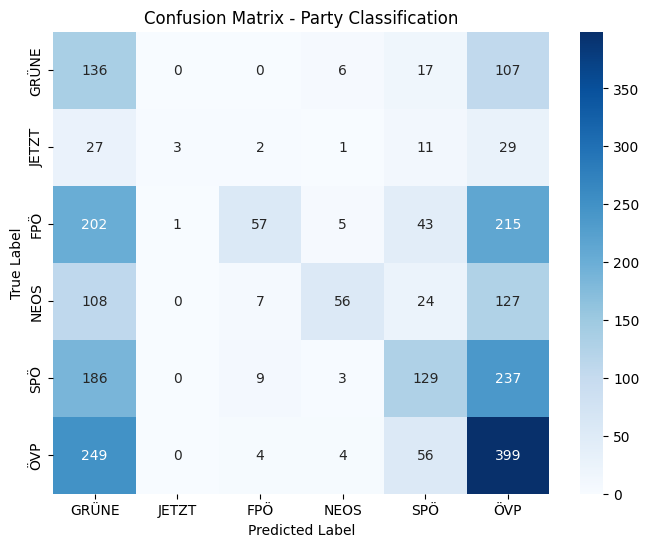

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix_party = confusion_matrix(
    df_party_qv['true_label'], 
    df_party_qv['Fine-tuned Qwen 3'], 
    labels=df_party_qv['true_label'].unique()
)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_party, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_party_qv['true_label'].unique(), yticklabels=df_party_qv['true_label'].unique())
plt.title('Confusion Matrix - Party Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./orient-confusion-qv')
plt.show()


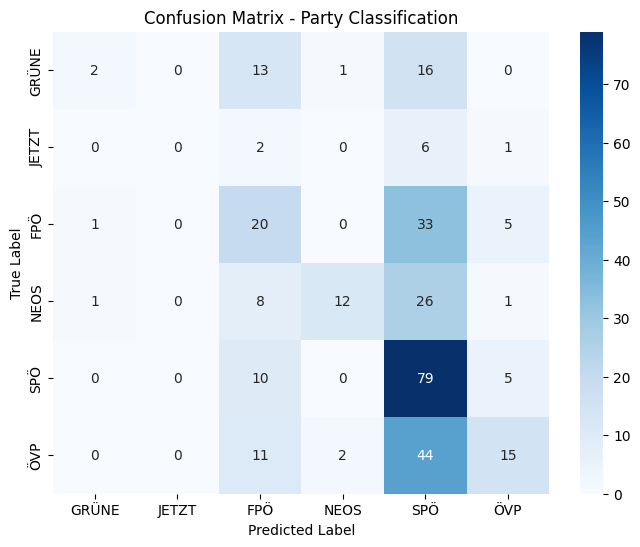

In [ ]:
'''conf_matrix_party = confusion_matrix(
    df_party_qv['true_label'], 
    df_party_qv['Base Qwen 3'], 
    labels=df_party_qv['true_label'].unique()
)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_party, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_party_qv['true_label'].unique(), yticklabels=df_party_qv['true_label'].unique())
plt.title('Confusion Matrix - Party Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./orient-confusion-qv')
plt.show()'''

C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\447447298.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exact_accuracies = [df['EA'][0], df['EA'][1]]
C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\447447298.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  partial_accuracies = [df['PA'][0], df['PA'][1]]
C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\447447298.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

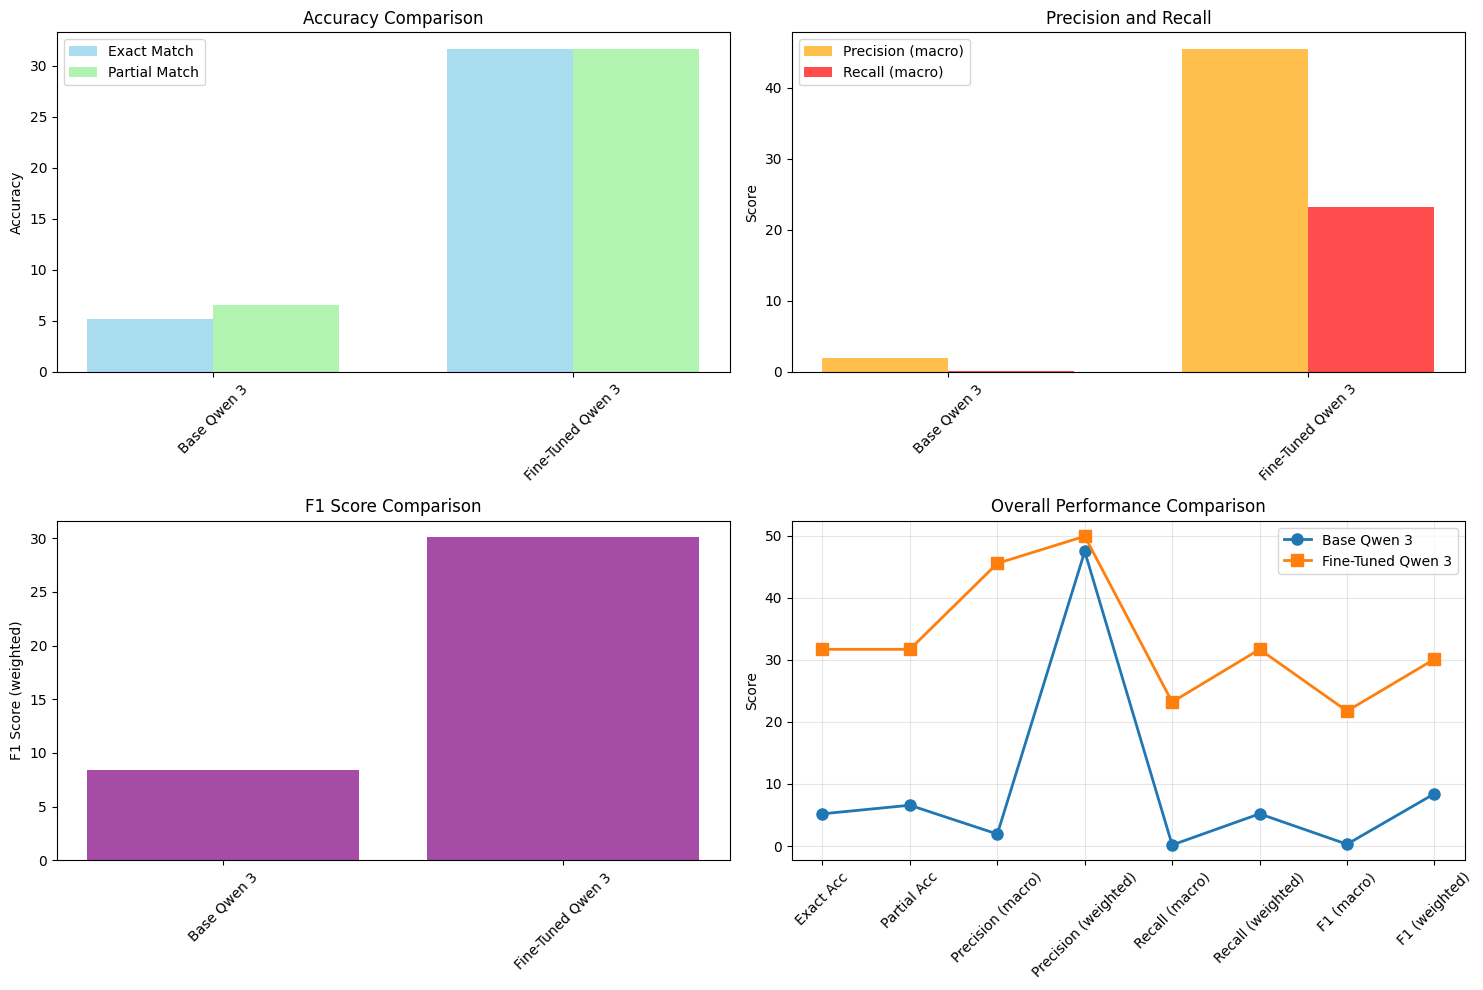

In [37]:
# Visualization
import numpy as np
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
model_names = ['Base Qwen 3', 'Fine-Tuned Qwen 3']
df = party_metrics_df
exact_accuracies = [df['EA'][0], df['EA'][1]]
partial_accuracies = [df['PA'][0], df['PA'][1]]
balanced_accuracies = [df['BA'][0], df['BA'][1]]
precisionsW = [df['P (w)'][0], df['P (w)'][1]]
recallsW = [df['R(w)'][0], df['R(w)'][1]]
f1_scoresW = [df['F1(w)'][0], df['F1(w)'][1]]
precisionsM = [df['P (m)'][0], df['P (m)'][1]]
recallsM = [df['R(m)'][0], df['R(m)'][1]]
f1_scoresM = [df['F1(m)'][0], df['F1(m)'][1]]

x = np.arange(len(model_names))
width = 0.35
axes[0, 0].bar(x - width/2, exact_accuracies, width, alpha=0.7, label='Exact Match', color='skyblue')
axes[0, 0].bar(x + width/2, partial_accuracies, width, alpha=0.7, label='Partial Match', color='lightgreen')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45)

axes[0, 1].bar(x - width/2, precisionsM, width, label='Precision (macro)', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recallsM, width, label='Recall (macro)', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

axes[1, 0].bar(model_names, f1_scoresW, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score (weighted)')
axes[1, 0].tick_params(axis='x', rotation=45)

metrics = ['Exact Acc', 'Partial Acc', 'Precision (macro)','Precision (weighted)',  'Recall (macro)', 'Recall (weighted)','F1 (macro)','F1 (weighted)']
base_scores = [exact_accuracies[0], partial_accuracies[0], precisionsM[0],precisionsW[0], recallsM[0], recallsW[0], f1_scoresM[0],f1_scoresW[0]]
ft_scores = [exact_accuracies[1], partial_accuracies[1], precisionsM[1],precisionsW[1], recallsM[1], recallsW[1], f1_scoresM[1],f1_scoresW[1]]

axes[1, 1].plot(metrics, base_scores, 'o-', label=model_names[0], linewidth=2, markersize=8)
axes[1, 1].plot(metrics, ft_scores, 's-', label=model_names[1], linewidth=2, markersize=8)
axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./evaluation-party-qv.png")
plt.show()

In [21]:
orient_metrics_summary = {}
orient_metrics_summary = get_metrics(df_orient_qv['Base Qwen 3'],df_orient_qv['Fine-tuned Qwen 3'],df_orient_qv['true_label'],orient_metrics_summary)

c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Estelle\miniconda3\envs\DeepLearn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

In [22]:
orient_metrics_df = (pd.DataFrame(orient_metrics_summary).T *100).round(2)

In [23]:
orient_metrics_df

,EA,PA,BA,P (m),R(m),F1(m),P (w),R(w),F1(w)
Base Qwen 3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fine-tuned Qwen 3,25.15,51.97,29.57,29.57,23.05,18.21,33.87,25.15,20.28


In [24]:
orient_metrics_df.to_latex(float_format="%.2f")

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n & EA & PA & BA & P (m) & R(m) & F1(m) & P (w) & R(w) & F1(w) \\\\\n\\midrule\nBase Qwen 3 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\\\\nFine-tuned Qwen 3 & 25.15 & 51.97 & 29.57 & 29.57 & 23.05 & 18.21 & 33.87 & 25.15 & 20.28 \\\\\n\\bottomrule\n\\end{tabular}\n'

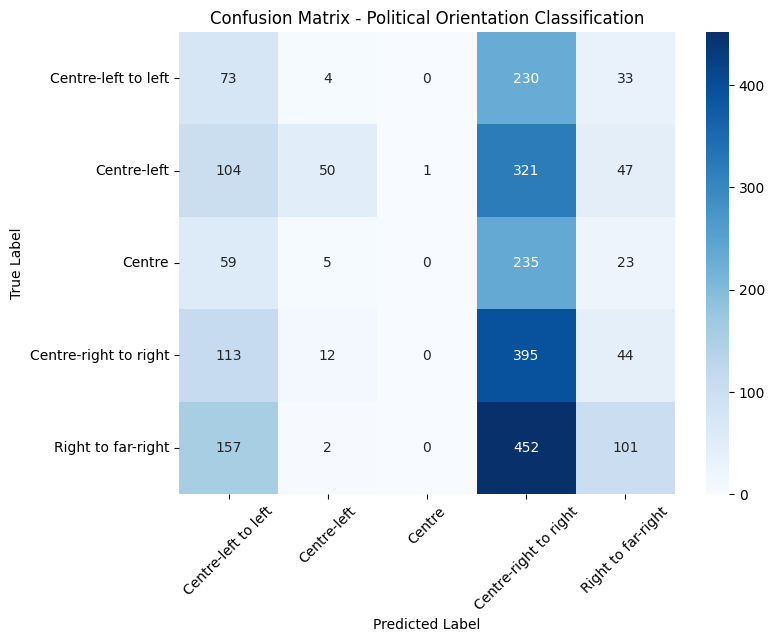

In [25]:
conf_matrix_orient = confusion_matrix(
    df_orient_qv['true_label'], 
    df_orient_qv['Fine-tuned Qwen 3'], 
    labels=df_orient_qv['true_label'].unique()
)
labels_orient = ['Centre-left to left', 'Centre-left', 'Centre', 'Centre-right to right', 'Right to far-right']
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_orient, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_orient, yticklabels=labels_orient)
plt.title('Confusion Matrix - Political Orientation Classification')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.ylabel('True Label')
plt.savefig('./orient-confusion-qv')
plt.show()


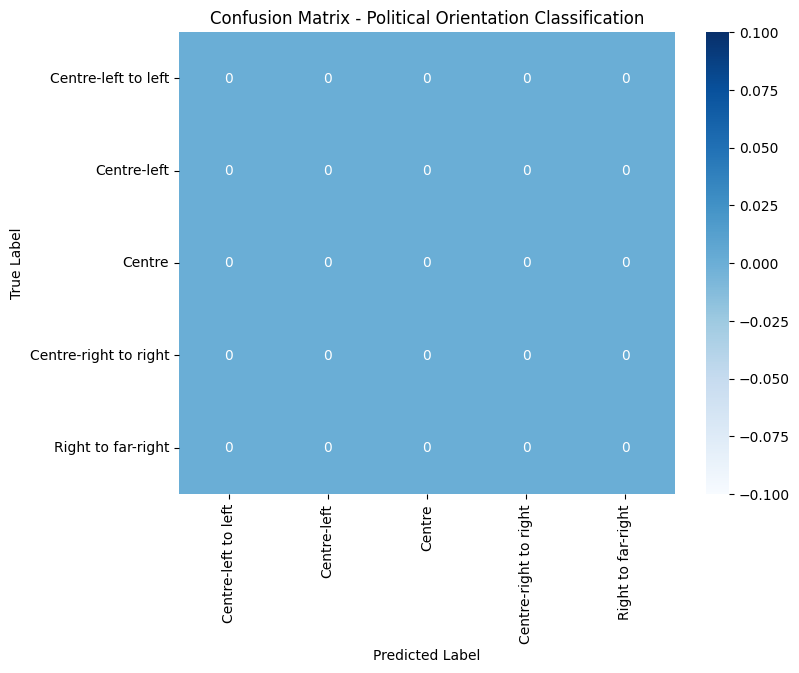

In [ ]:
'''conf_matrix_orient = confusion_matrix(
    df_orient_qv['true_label'], 
    df_orient_qv['Base Qwen 3'], 
    labels=df_orient_qv['true_label'].unique()
)
labels_orient = ['Centre-left to left', 'Centre-left', 'Centre', 'Centre-right to right', 'Right to far-right']
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_orient, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_orient, yticklabels=labels_orient)
plt.title('Confusion Matrix - Political Orientation Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./orient-confusion-qv')
plt.show()'''

In [26]:
orient_metrics_df

,EA,PA,BA,P (m),R(m),F1(m),P (w),R(w),F1(w)
Base Qwen 3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fine-tuned Qwen 3,25.15,51.97,29.57,29.57,23.05,18.21,33.87,25.15,20.28


C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\2055468745.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exact_accuracies = [df['EA'][0], df['EA'][1]]
C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\2055468745.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  partial_accuracies = [df['PA'][0], df['PA'][1]]
C:\Users\Estelle\AppData\Local\Temp\ipykernel_32596\2055468745.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

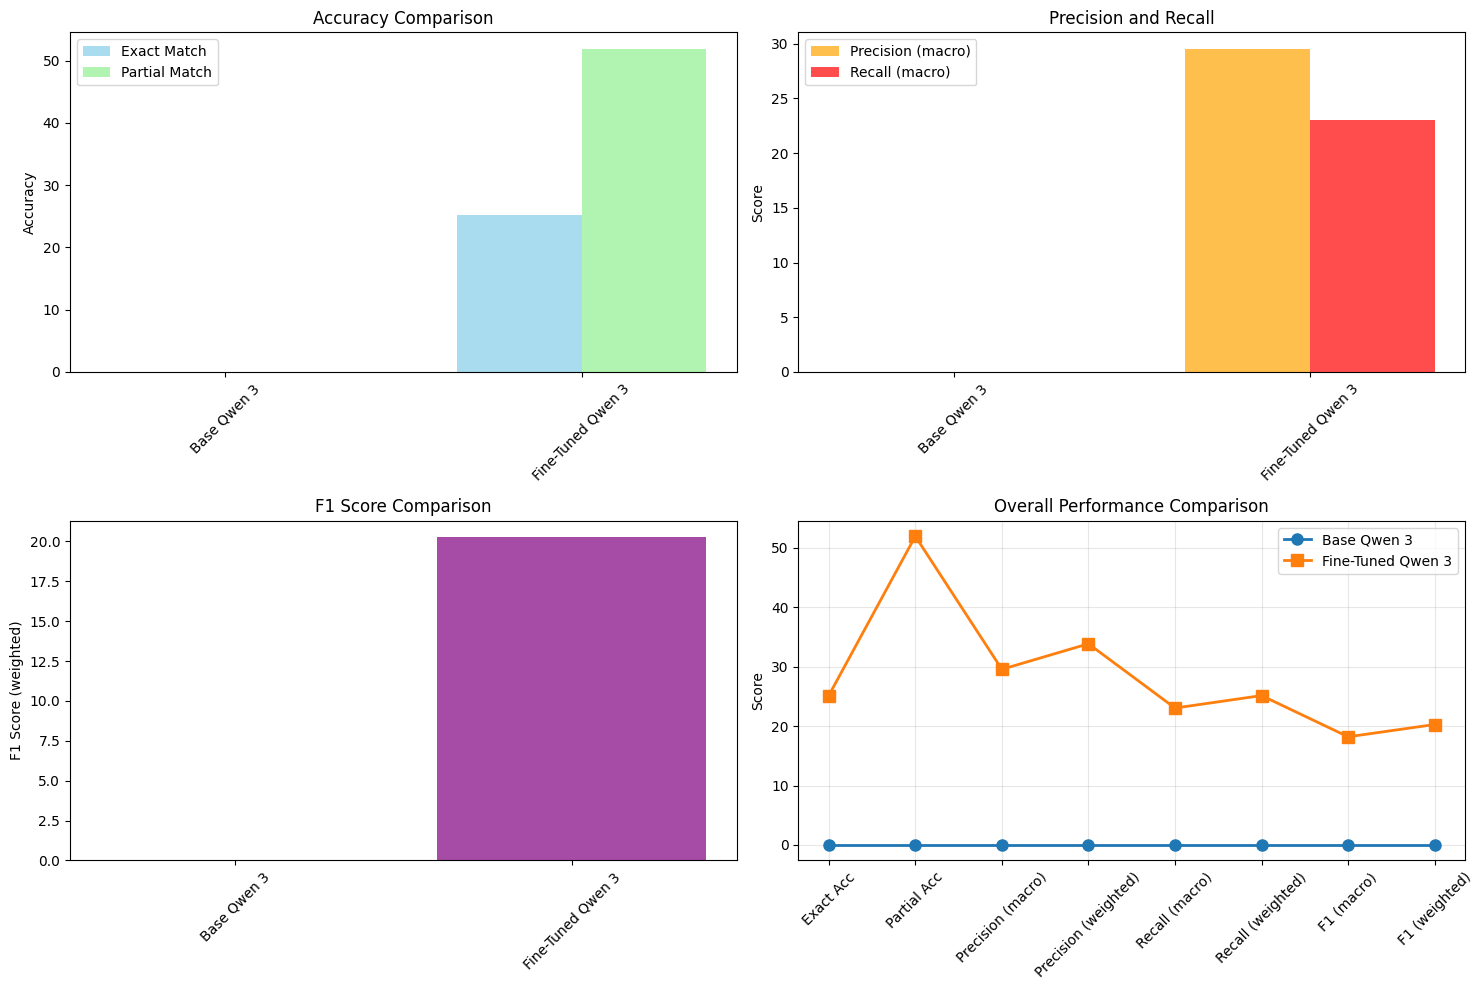

In [38]:
# Visualization
import numpy as np
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
model_names = ['Base Qwen 3', 'Fine-Tuned Qwen 3']
df = orient_metrics_df
exact_accuracies = [df['EA'][0], df['EA'][1]]
partial_accuracies = [df['PA'][0], df['PA'][1]]
balanced_accuracies = [df['BA'][0], df['BA'][1]]
precisionsW = [df['P (w)'][0], df['P (w)'][1]]
recallsW = [df['R(w)'][0], df['R(w)'][1]]
f1_scoresW = [df['F1(w)'][0], df['F1(w)'][1]]
precisionsM = [df['P (m)'][0], df['P (m)'][1]]
recallsM = [df['R(m)'][0], df['R(m)'][1]]
f1_scoresM = [df['F1(m)'][0], df['F1(m)'][1]]

x = np.arange(len(model_names))
width = 0.35
axes[0, 0].bar(x - width/2, exact_accuracies, width, alpha=0.7, label='Exact Match', color='skyblue')
axes[0, 0].bar(x + width/2, partial_accuracies, width, alpha=0.7, label='Partial Match', color='lightgreen')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45)

axes[0, 1].bar(x - width/2, precisionsM, width, label='Precision (macro)', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recallsM, width, label='Recall (macro)', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

axes[1, 0].bar(model_names, f1_scoresW, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score (weighted)')
axes[1, 0].tick_params(axis='x', rotation=45)

metrics = ['Exact Acc', 'Partial Acc', 'Precision (macro)','Precision (weighted)',  'Recall (macro)', 'Recall (weighted)','F1 (macro)','F1 (weighted)']
base_scores = [exact_accuracies[0], partial_accuracies[0], precisionsM[0],precisionsW[0], recallsM[0], recallsW[0], f1_scoresM[0],f1_scoresW[0]]
ft_scores = [exact_accuracies[1], partial_accuracies[1], precisionsM[1],precisionsW[1], recallsM[1], recallsW[1], f1_scoresM[1],f1_scoresW[1]]

axes[1, 1].plot(metrics, base_scores, 'o-', label=model_names[0], linewidth=2, markersize=8)
axes[1, 1].plot(metrics, ft_scores, 's-', label=model_names[1], linewidth=2, markersize=8)
axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./evaluation-orient-qv.png")
plt.show()